In [23]:
# This file estimates the transition matrix M, which shows the probability of a vote for party-i upon elimination being distributed to party-j.

In [24]:
# imports
import pandas as pd
import numpy as np
import os,sys

In [25]:
distribution_folders = os.listdir("dop_data")
distribution_files = []
for folder in distribution_folders:
    subfiles = os.listdir(f"dop_data/{folder}")
    for subfile in subfiles:
        distribution_files.append(f"dop_data/{folder}/{subfile}")

In [26]:
distribution_polling_place = pd.read_csv(distribution_files[0],header=1)
for file in distribution_files[1:]:
    distribution_polling_place = pd.concat([
        distribution_polling_place, pd.read_csv(file,header=1)
    ], ignore_index=True)

In [27]:
distribution_polling_place

,StateAb,DivisionId,DivisionNm,PPId,PPNm,CountNum,BallotPosition,CandidateId,Surname,GivenNm,PartyAb,PartyNm,SittingMemberFl,CalculationType,CalculationValue
0,ACT,318,Bean,0,ABSENT,0,1,36239,CONWAY,Sean,UAPP,United Australia Party,N,Preference Count,72.00
1,ACT,318,Bean,0,ABSENT,0,1,36239,CONWAY,Sean,UAPP,United Australia Party,N,Preference Percent,4.32
2,ACT,318,Bean,0,ABSENT,0,1,36239,CONWAY,Sean,UAPP,United Australia Party,N,Transfer Count,0.00
3,ACT,318,Bean,0,ABSENT,0,1,36239,CONWAY,Sean,UAPP,United Australia Party,N,Transfer Percent,0.00
4,ACT,318,Bean,0,ABSENT,0,2,37455,AMBARD,Aethan Benjamin Robert,ON,Pauline Hanson's One Nation,N,Preference Count,49.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132811,WA,248,Tangney,108575,EAV COVID19 Tangney PPVC,7,8,37283,HOLROYD,Jacqueline Nicole,LDP,Liberal Democratic Party,N,Transfer Percent,0.00
2132812,WA,248,Tangney,108575,EAV COVID19 Tangney PPVC,7,9,36635,ABDUL RAZAK,Adam Shahabuddin,GRN,The Greens (WA) Inc,N,Preference Count,0.00
2132813,WA,248,Tangney,108575,EAV COVID19 Tangney PPVC,7,9,36635,ABDUL RAZAK,Adam Shahabuddin,GRN,The Greens (WA) Inc,N,Preference Percent,0.00
2132814,WA,248,Tangney,108575,EAV COVID19 Tangney PPVC,7,9,36635,ABDUL RAZAK,Adam Shahabuddin,GRN,The Greens (WA) Inc,N,Transfer Count,-239.00


In [28]:
# load in the data
distribution_data = pd.read_csv("../data/historical_election_data/HouseDopByDivisionDownload-27966.csv",header=1)
distribution_data.head()
distribution_data = distribution_polling_place

In [29]:
teal_candidates = pd.read_csv("teal.csv")
teal_candidates.head()


,DivisionNm,Surname,GivenNm
0,Boothby,DYER,Jo
1,Bradfield,BOELE,Nicolette
2,Calare,HOOK,Kate
3,Casey,FERRES MILES,Claire
4,Cowper,HEISE,Caz


In [30]:
parties_collected = ['UAPP', 'ON', 'ALP', 'IND', 'GRN', 'LP','NP','CLP','LNP','XEN', 'KAP']
party_mappers = {
    'UAPP':'UAP', 
    'ON':'ONP',
    'ALP':'ALP', 
    'IND':'IND', 
    'GRN':'GRN',
    'GVIC':'GRN',
    'LP':'LNP',
    'NP':'LNP',
    'CLP':'LNP',
    'LNP':'LNP',
    'XEN':'IND',
    'KAP':'IND',
}

# modeled_parties = ['UAP', 'ONP', 'ALP', 'GRN', 'LIB', 'NAT', 'CLP', 'LNP', 'IND', 'KAP', 'TEAL', 'OTH']
modeled_parties = ['UAP', 'ONP', 'ALP', 'GRN', 'LNP', 'IND', 'TEAL', 'OTH']

for idx,teal in teal_candidates.iterrows():
    givenNm = teal['GivenNm']
    surname = teal['Surname']
    division = teal['DivisionNm']
    distribution_data.loc[(distribution_data[['GivenNm','Surname','DivisionNm']]==[givenNm,surname,division]).all(axis=1),'PartyAb']="TEAL"

def partymap(row):
    party = row['PartyAb']
    if party in modeled_parties:
        party = party
    elif party in party_mappers.keys():
        party = party_mappers[party]
    elif pd.isna(party):
        if pd.isna(row['Surname']):
            party = "Informal"
        else:
            party = "IND"
    else:
        party = "OTH"
    row['PartyAb'] = party
    return row

distribution_data = distribution_data.apply(partymap,axis=1)

In [63]:
distribution_data["CountNumber"] = distribution_data["CountNum"]
# distribution_data["CountNumber"] = (distribution_data["CountNum"].astype(str) + "_" + distribution_data["PPId"].astype(str))

In [64]:
# initial clean ups
# Remove rows contianing calculatype==Preference Count - keep Preference Percent
distribution_data_cleaned = distribution_data[(distribution_data["CalculationType"] == "Transfer Percent") & (distribution_data["CountNumber"] > 0) & (distribution_data["PartyAb"] != "Informal")]
columns_to_keep = ["DivisionNm", "CountNumber", "PPId", "Surname", "PartyAb", "CalculationValue"]
distribution_data_cleaned = distribution_data_cleaned[columns_to_keep]
distribution_data_cleaned.head()

,DivisionNm,CountNumber,PPId,Surname,PartyAb,CalculationValue
27,Bean,1,0,CONWAY,UAP,51.02
31,Bean,1,0,AMBARD,ONP,-100.00
35,Bean,1,0,SMITH,ALP,12.24
39,Bean,1,0,CHRISTIE,IND,16.33
43,Bean,1,0,SAVERY,GRN,2.04


In [65]:
len(modeled_parties)

8

In [66]:
def fixrow(row):
    posvalues = row >0
    row[posvalues] = row[posvalues] / row[posvalues].sum()
    row[row<0] = -1
    return row

In [67]:
X = distribution_data_cleaned.pivot_table(index=['DivisionNm', 'CountNumber', "PPId"], columns='PartyAb', values='CalculationValue', aggfunc='sum')
X.columns.name = None
X =X.apply(fixrow, axis=1).copy()
X.head()

ALP       GRN  IND       LNP       ONP  OTH  \
DivisionNm CountNumber PPId                                                    
Adelaide   1           0     0.11466  0.124445  NaN  0.102388  0.356974 -1.0   
                       6648  0.00000  0.666667  NaN  0.000000  0.333333 -1.0   
                       6649  0.00000  0.000000  NaN  0.000000  0.749963 -1.0   
                       6651  0.12500  0.000000  NaN  0.125000  0.375000 -1.0   
                       6654  0.20000  0.200000  NaN  0.300000  0.200000 -1.0   

                             TEAL       UAP  
DivisionNm CountNumber PPId                  
Adelaide   1           0      NaN  0.301532  
                       6648   NaN  0.000000  
                       6649   NaN  0.250037  
                       6651   NaN  0.375000  
                       6654   NaN  0.100000

In [68]:
X.shape

(51916, 8)

In [ ]:
np.random.seed(42)
# M0 = np.random.rand(len(modeled_parties), len(modeled_parties)).round(2)
# M0 = M0 - np.diag(M0)*np.eye(len(modeled_parties))
# M0 = M0 / M0.sum(axis=1, keepdims=True)
# print(M0)
M0df = pd.read_csv("M0.csv",index_col='PartyAb')
M0 = M0df.to_numpy().T



In [ ]:
M0

array([[0.  , 0.1 , 0.05, 0.05, 0.1 , 0.1 , 0.05, 0.1 ],
       [0.1 , 0.  , 0.05, 0.05, 0.1 , 0.1 , 0.05, 0.1 ],
       [0.1 , 0.2 , 0.  , 0.3 , 0.5 , 0.1 , 0.35, 0.1 ],
       [0.1 , 0.05, 0.3 , 0.  , 0.05, 0.1 , 0.25, 0.1 ],
       [0.4 , 0.4 , 0.2 , 0.2 , 0.  , 0.15, 0.1 , 0.2 ],
       [0.1 , 0.1 , 0.05, 0.05, 0.05, 0.  , 0.1 , 0.2 ],
       [0.1 , 0.05, 0.25, 0.25, 0.15, 0.2 , 0.  , 0.2 ],
       [0.1 , 0.1 , 0.1 , 0.1 , 0.05, 0.25, 0.1 , 0.  ]])

In [ ]:
def H(y,M, tol=1e-5, max_iter=100):
    '''
    Inputs:
    y: Observation (vector of length modeled_parties)x
    M: Transition matrix (num_parties x num_parties)
    tol: Tolerance for convergence. Default is 1e-6
    max_iter: Maximum number of iterations. Default is 100
    Outputs:
    yhat: Predicted observation

    Description:
    Position of nan in y indicates already eliminated parties.

    Position of negative value in y indicates the party to be eliminated.

    Distribute a vector of 1 for eliminated party according to M.as_integer_ratio

    If nan parties have value less than tolerance then set to 0.

    Check if already eliminated parties received votes. If did then distribute those.

    Repeat
    '''
    def check_all_eliminated(yhat, valid_parties):
        eliminated = ~valid_parties
        return np.all(yhat[eliminated]<tol)
    def set_eliminated(yhat, valid_parties, party_i):
        eliminated = ~valid_parties
        yhat[eliminated] = np.nan
        yhat = yhat / np.nansum(yhat)
        yhat[party_i] = -1
        return yhat
    def pref_flow(yhat, idx, M):
        ''' Eliminate idx and distribute preferences according to M. Ignores any elimination'''


        flow = np.zeros_like(yhat)
        flow[idx] = yhat[idx]
        flow = M @ flow
        yhat[idx] = 0
        return yhat[idx] + flow
    party_i = np.where(y==-1)[0][0] #np.argmin(y) # Index of party to be eliminated

    valid_parties = ~np.isnan(y) # Boolean array of uneliminated parties
    valid_parties[party_i] = False # Exclude party to be eliminated

    yhats = []

    yhat =  np.zeros_like(y)
    yhat[party_i] = 1
    yhats.append(yhat.copy())
    yhat = M @ yhat
    yhats.append(yhat.copy())
    if check_all_eliminated(yhat, valid_parties):
        return set_eliminated(yhat, valid_parties,party_i)
    

    for _ in range(max_iter):
        for eliminated in np.where(~valid_parties)[0]:
            if yhat[eliminated]>tol:
                yhat = pref_flow(yhat,eliminated, M)
                yhats.append(yhat.copy())

            if check_all_eliminated(yhat, valid_parties):
                return set_eliminated(yhat, valid_parties, party_i)

    print("WARNING: Did not converge")
    return set_eliminated(yhat,valid_parties, party_i)

In [ ]:
def forecast_preference_flow(y, M, tol=1e-4, max_iter=100):
    """
    Forecast ranked choice voting outcomes by recursively redistributing vote mass 
    from eliminated parties according to the transition matrix M.

    Parameters
    ----------
    y : np.ndarray
        A column vector (n x 1) with entries:
            - -1 for the party to be eliminated (its vote mass will be redistributed),
            - np.nan for parties already eliminated,
            - Positive values for parties still active.
        (Note: y is assumed to come from something like pd.Series.to_numpy().reshape(-1, 1)).
        
    M : np.ndarray
        A square transition matrix (n x n) where M[i, j] is the fraction of votes from party j 
        that flow to party i when party j is eliminated.
        (Under the assumption that all parties are active; note that the diagonal must be 0.)
        
    tol : float, optional
        Tolerance threshold (default 1e-5). Redistribution from an eliminated party stops
        once its vote mass falls below this level.
        
    max_iter : int, optional
        Maximum number of redistribution iterations (default 100).

    Returns
    -------
    final_yhat : np.ndarray
        A column vector (n x 1) forecast in which:
            - The valid (active) parties have vote shares that sum to 1,
            - Parties originally eliminated (np.nan in y) are set to np.nan,
            - The party that is eliminated this round (originally -1 in y) is marked with -1.
    history : list of np.ndarray
        A list of the intermediate forecast vectors (yhat) at each redistribution step.
    """
    # Ensure y is a column vector and determine the number of parties
    y = y.reshape(-1, 1)
    n = y.shape[0]

    # Identify the party to be eliminated (it should have value -1).
    elim_indices = np.where(y.flatten() == -1)[0]
    if elim_indices.size != 1:
        raise ValueError("There must be exactly one party with -1 in y")
    elim_idx = elim_indices[0]

    # Determine which parties are valid (i.e. still active). Here, valid parties are those
    # that are not np.nan. Also, treat the party to be eliminated as invalid.
    valid = ~np.isnan(y.flatten())
    valid[elim_idx] = False  # the party to be eliminated is considered eliminated

    # Initialize the forecast vector (yhat) as a column vector:
    # Start by placing full vote mass (1.0) on the eliminated party.
    yhat = np.zeros((n, 1))
    yhat[elim_idx, 0] = 1.0

    # Save the history of iterations (for debugging/inspection)
    history = [yhat.copy()]

    # Use a view (1D) of yhat for easier (vectorized) manipulation.
    yhat_vec = yhat.ravel()

    # Iteratively redistribute vote mass from eliminated parties until convergence.
    for iteration in range(max_iter):
        # Find indices of eliminated parties (i.e. not valid) that have vote mass above tol.
        # (Note: valid is a boolean array of length n.)
        redistribute_indices = np.where((~valid) & (yhat_vec > tol))[0]
        if redistribute_indices.size == 0:
            # No eliminated party has vote mass above tolerance => convergence.
            break

        # For each such party j, we remove its vote mass and redistribute it via column j of M.
        # In a vectorized step, we compute the total redistributed vote mass from all such parties.
        vote_masses = yhat_vec[redistribute_indices]  # shape: (k,)
        # Zero out the vote mass for these eliminated parties.
        yhat_vec[redistribute_indices] = 0.0
        # Compute the new votes added from the redistribution.
        # M[:, redistribute_indices] is (n x k) and vote_masses (k,) will broadcast properly.
        redistributed = (M[:, redistribute_indices] * vote_masses).sum(axis=1)
        # Add the redistributed votes to the current forecast.
        yhat_vec += redistributed

        # Update yhat (as a column vector) and store the current state.
        yhat = yhat_vec.reshape(-1, 1)
        history.append(yhat.copy())
    else:
        print("WARNING: Did not converge within max_iter iterations")

    # Finalize the forecast:
    #   - Set all parties that are eliminated (i.e. not valid) to np.nan.
    #   - Normalize the vote mass among valid parties so that their total is 1.
    #   - Reset the originally eliminated party to -1.
    final_yhat = yhat.copy()
    final_yhat[~valid] = np.nan
    valid_sum = np.nansum(yhat[valid])
    if valid_sum > 0:
        final_yhat[valid] = yhat[valid] / valid_sum
    final_yhat[elim_idx] = -1.0

    return final_yhat#, history


In [ ]:
from tqdm import tqdm

def metropolis(X, M0, temperature=1e-2, tdecay_rate=0.99, max_iter=20000, tol=0.15):
    M = M0.copy()
    def residuals(y,yhat):
        return np.sqrt(np.nansum((yhat - y)**2))
    def paccept(temp, error):
        return np.exp(-np.abs(error)/temp)
    def perturb(M):
        Msuggest = M.copy()
        i = np.random.randint(0,len(Msuggest))
        j = np.random.choice([val for val in range(len(Msuggest)) if val != i])    
        Msuggest[i,j] = np.clip(Msuggest[i,j]*np.random.uniform(0.95,1.05),0,1)
        Msuggest = Msuggest / Msuggest.sum(axis=1, keepdims=True)

        return Msuggest
    total_errs = []

    errs = []
    for idx, x in X.iterrows():
        y = x.to_numpy().reshape(-1,1)
        yhat = H(y,M)
        errs.append(residuals(y,yhat))
    total_err = np.mean(errs)
    total_errs.append(total_err)

    counter = 0
    # while counter < max_iter:
    for _ in tqdm(range(max_iter)):

        suggested_M = perturb(M)
        errs = []
        for idx, x in X.iterrows():
            y = x.to_numpy().reshape(-1,1)
            yhat = H(y,suggested_M)
            errs.append(residuals(y,yhat))
        suggested_total_err = np.mean(errs)
        if suggested_total_err < total_err:
            M = suggested_M
            total_err = suggested_total_err
            

        else:
            if np.random.rand() < paccept(temperature, suggested_total_err - total_err):
                M = suggested_M
                total_err = suggested_total_err
                

        temperature = temperature * tdecay_rate
        total_errs.append(total_err)
        if total_err < tol:
            break

        counter += 1
    return M, total_errs

In [ ]:
M, total_errs = metropolis(X, M0)
pd.DataFrame(M, columns=modeled_parties,index=modeled_parties).to_csv('M.csv')

100%|██████████| 2000/2000 [06:39<00:00,  5.01it/s]


In [ ]:
Madjusted = M.copy()
Madjusted[4,:] = Madjusted[4,:]


In [ ]:
for i in range(len(modeled_parties)):
    Madjusted[:,i] = Madjusted[:,i] / Madjusted[:,i].sum() 

In [ ]:
Madjusted[2,:].sum()

1.0255372075188316

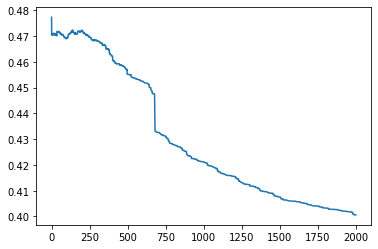

In [ ]:
import matplotlib.pyplot as plt

plt.plot(total_errs)

In [ ]:
def TCP(y,M, tol=1e-4, max_iter=1000):
    # eliminated = np.array([False]*len(y)).reshape(-1,1)
    # eliminated[np.isnan(y)] = True # Parties not running are eliminated
    yhats = []
    yhat = y.copy()
    yhats.append(yhat.copy())
    yhat[np.isnan(yhat)] = 0
    for _ in range(max_iter):
        argssorted = np.argsort(yhat.reshape(-1))
        argssorted = argssorted[yhat.reshape(-1)[argssorted]>0] # Remove parties that are eliminated
        smallest_remaining_party = argssorted[0] # Index of smallest remaining party
        
        flow = np.zeros_like(yhat)
        flow[smallest_remaining_party] = 1
        flow =  M @ flow

        yhat = yhat + flow*yhat[smallest_remaining_party]
        yhat[smallest_remaining_party,0] = 0

        yhat[yhat<tol] = 0
        yhat = yhat / np.nansum(yhat)
        yhats.append(yhat.copy())

        if sum(yhat!=0)[0] == 2:
            return yhat ,yhats#, eliminated
    print("WARNING: Did not converge")
    return yhat,yhats

In [ ]:
d= distribution_data[(distribution_data['CalculationType']=="Preference Percent") & (distribution_data['CountNumber']==0) & (distribution_data['DivisionNm']=="Curtin")]
primary = pd.pivot_table(d, index=['StateAb', 'DivisionID', 'DivisionNm'], columns='PartyAb', values='CalculationValue', aggfunc='sum')
for party in modeled_parties:
    if party not in primary.columns:
        primary[party] = np.nan
primarynumpy = primary.reindex(modeled_parties,axis=1).to_numpy().reshape(-1,1)
primarynumpy = primarynumpy / np.nansum(primarynumpy)

In [ ]:
primary.reindex(modeled_parties,axis=1)

,,PartyAb,UAP,ONP,ALP,GRN,LNP,IND,TEAL,OTH
StateAb,DivisionID,DivisionNm,,,,,,,,
WA,238,Curtin,1.74,1.25,13.95,10.37,41.33,NaN,29.46,1.91


In [ ]:
y, ys = TCP(primarynumpy,M)
pd.Series(y.reshape(-1),index=modeled_parties)

UAP     0.000000
ONP     0.000000
ALP     0.000000
GRN     0.000000
LNP     0.549177
IND     0.000000
TEAL    0.450823
OTH     0.000000
dtype: float64

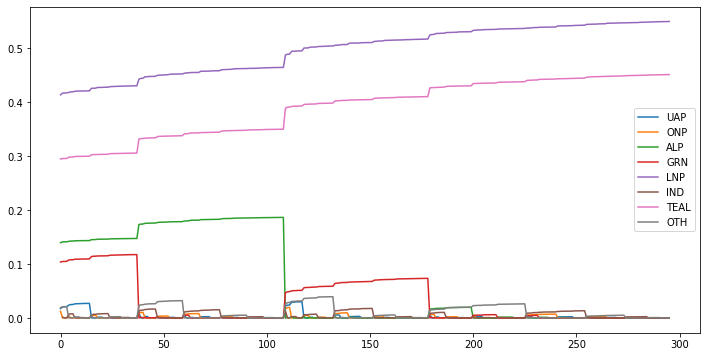

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
pd.DataFrame(np.concatenate(ys, axis=1).T, columns=modeled_parties).plot(ax=ax)
plt.show()